# Evaluate on Test Data

## Setup

In [1]:
from importlib import reload

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas

from hot_dust import preprocess, model

In [9]:
# "reload" to get changes in preprocess.py without restarting the kernel
reload(preprocess)
reload(model)
from hot_dust.preprocess import prepare_training_data, split_training_data, sensitivity_analysis
from hot_dust.model import to_tensorflow

In [10]:
ds = prepare_training_data()
train, validate, test = to_tensorflow(split_training_data(ds))
batch_size = test.cardinality()
test = test.batch(batch_size)   
ds

<xarray.Dataset>
Dimensions:   (sample: 250000, features: 8, output_dim: 2)
Coordinates:
  * features  (features) <U20 'viewing_zenith_angle' 'spress' ... 'bt_12000'
Dimensions without coordinates: sample, output_dim
Data variables:
    x         (sample, features) float32 64.0 1.013e+03 68.42 ... 250.2 250.0
    y         (sample, output_dim) float32 -1.826 291.8 -0.4952 ... 0.3864 271.6
    split     (sample) <U8 'train' 'train' 'train' ... 'train' 'train' 'train'
Attributes:
    description:             Radiative transfer-based labelled training data ...
    suffix:                  nc
    version:                 20230803
    contact_person_address:  NASA/GSFC, Mail Code 616, 8800 Greenbelt Road, G...
    contact_person_email:     andrew.sayer@nasa.gov
    contact_person_name:      Andrew Sayer
    contact_person_role:     Scientific/technical contact
    data_set_language:       en
    file_format:             NetCDF4

## Model Summary

In [11]:
network = tf.keras.models.load_model("data/network", compile=False)
network.summary() 


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 normalization_1 (Normalization  (None, 8)           17          ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 dense_2 (Dense)                (None, 16)           144         ['normalization_1[0][0]']        
                                                                                                  
 dense_3 (Dense)                (None, 16)           272         ['dense_2[0][0]']          

## Metrics

In [12]:
# Calculate metrics (.eg MSE, R2) on test data and tabulate

y = np.concatenate(list(i[1] for i in test.as_numpy_iterator()))  # true values
y_hat = np.array(network.predict(test, verbose=0))  # predicted values 

# Calculate the MSE
MSE_1 = np.square(np.subtract(y[:, 0], y_hat[:, 0])).mean()  # MSE for first output
MSE_2 = np.square(np.subtract(y[:, 1], y_hat[:, 1])).mean()  # MSE for second output
MSE = (MSE_1 + MSE_2) / 2  # MSE of both outputs 

# Calculate R2
y_mean = np.mean(y)  # mean of the true values
SS_total = np.sum((y - y_mean) ** 2)  # total sum of squares
SS_reg = np.sum((y - y_hat) ** 2)  #  sum of squares due to regression

R2 = 1 - (SS_reg / SS_total)

# Return the metrics
print("Metrics: ")
print("Mean Squared Error: " + str(MSE))
print("R2: " + str(R2))

Metrics: 
Mean Squared Error: 20091.484375
R2: -0.9983209371566772


## Plots

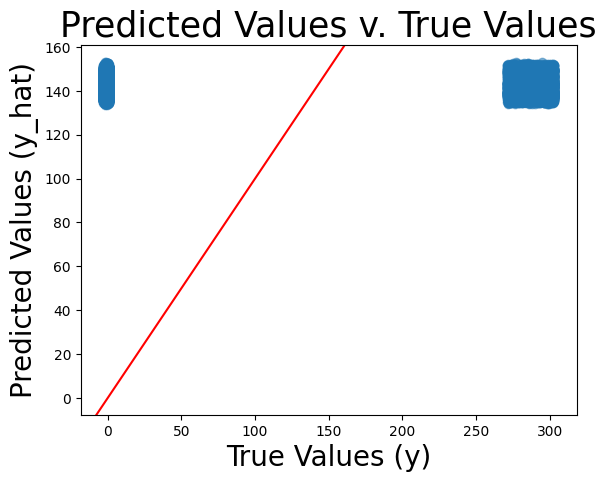

In [13]:
# Plot of y_hat against y, with a one-to-one line overlayed
# plot y_hat against y
plt.scatter(y, y_hat, alpha=0.5)

# lables
plt.xlabel("True Values (y)", fontsize=20)
plt.ylabel("Predicted Values (y_hat)", fontsize=20)
plt.title("Predicted Values v. True Values", fontsize=25)

# one-to-one line overlay
plt.axline([0, 0], slope=1, color="red")

ValueError: x must have 2 or fewer dimensions

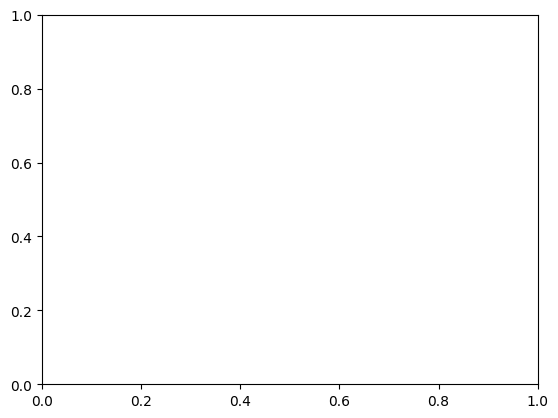

In [14]:
# Plot a histogram of the residuals
residual = y_hat - y
num_bins = 100
plt.hist(residual, num_bins)
plt.title("Histogram of the Residuals", fontsize=25)
plt.xlabel("Residuals", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.show()

ValueError: x and y must be the same size

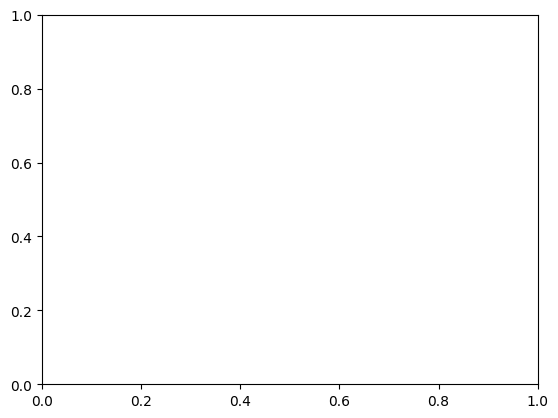

In [15]:
# Plot of the residuals against y
plt.scatter(y, residual, alpha=0.5)
# lables
plt.xlabel("True Values (y)", fontsize=20)
plt.ylabel("Residuals", fontsize=20)
plt.title("Residuals v. True Values", fontsize=25)

## Heat Maps 

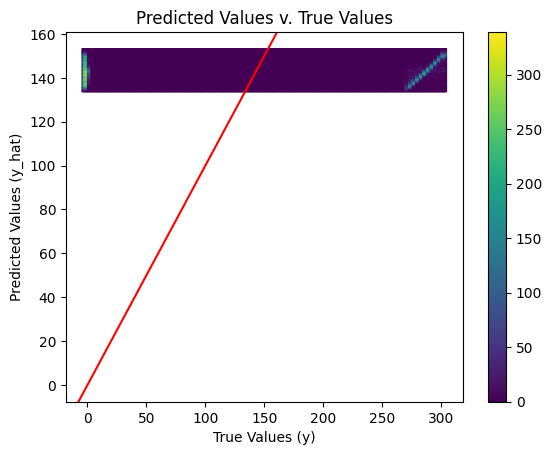

In [16]:
# Heat map of y_hat against y

# create the heatmap of y_hat against y
plt.hexbin(y, y_hat, cmap="viridis")
# set the size of the graph
plt.axis("auto")
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Predicted Values (y_hat)")
plt.title("Predicted Values v. True Values")
# one-to-one line overlay
plt.axline([0, 0], slope=1, color="red")
plt.colorbar()

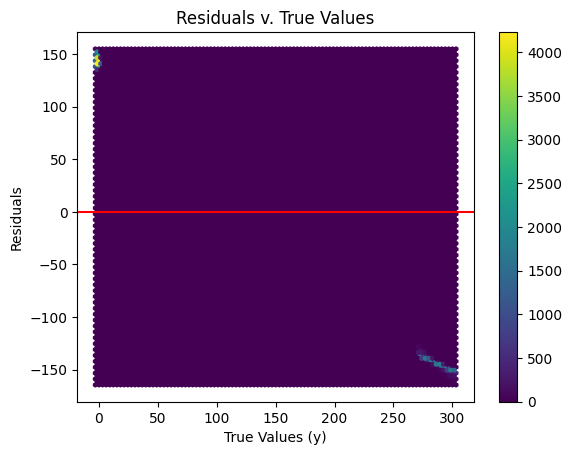

In [17]:
# Heat map of the residuals against y

# create the heatmap of residuals against y
plt.hexbin(y, residual, cmap="viridis")
# set the size of the graph
plt.axis("auto")
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Residuals")
plt.title("Residuals v. True Values")
# zero horizontal line overlay
plt.axline([0, 0], slope=0, color="red")
plt.colorbar()

## Sensitivity Analysis

In [18]:
percentage = 2 # in %; 2%, 5%, 10%
sensitivity_analysis(ds, network, percentage)

7813/7813 [==============================] - 11s 1ms/step


TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [ ]:
# TODO test on a grnaule put on the same plot 